In [1]:
import pandas as pd

In [2]:
path = "../dataset/train.csv"
df = pd.read_csv(path)

In [3]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["loan_status",'id'])
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'),[4, 2, 9]),
        ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
         [5]),  # Adjusted indices after dropping 'id'
        ('scaler', StandardScaler(), 
         [0, 1, 3, 6, 7, 8, 10])  # Adjusted indices after dropping 'id'
    ], remainder='passthrough'
)

In [5]:
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [6]:
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                                   scoring='accuracy', n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print best parameters
print(random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rat

In [7]:
# {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}

# Train the model with best parameters
xgb = XGBClassifier(subsample=1.0, n_estimators=300, max_depth=5, learning_rate=0.05, gamma=0.2, colsample_bytree=0.8)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def fit_and_score(model,name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # score = model.score(X_test, y_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'{name} model')
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Classification Report: \n{classification_report(y_test, y_pred)}')
    print('\n')



In [11]:
fit_and_score(xgb, 'XGBoost', X_train, X_test, y_train, y_test)

XGBoost model
Accuracy: 0.9545570807400461
Precision: 0.9399538106235565
Recall: 0.7285202863961814
F1 Score: 0.8208403361344537
Confusion Matrix: 
[[9975   78]
 [ 455 1221]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10053
           1       0.94      0.73      0.82      1676

    accuracy                           0.95     11729
   macro avg       0.95      0.86      0.90     11729
weighted avg       0.95      0.95      0.95     11729





In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
fit_and_score(rfc, 'Random Forest', X_train, X_test, y_train, y_test)

Random Forest model
Accuracy: 0.9530224230539688
Precision: 0.9467831612390787
Recall: 0.711217183770883
F1 Score: 0.8122657580919932
Confusion Matrix: 
[[9986   67]
 [ 484 1192]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10053
           1       0.95      0.71      0.81      1676

    accuracy                           0.95     11729
   macro avg       0.95      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729





In [13]:
rf = RandomForestClassifier()

In [15]:
x = XGBClassifier()
fit_and_score(x, 'Random Forest', X_train, X_test, y_train, y_test)

Random Forest model
Accuracy: 0.9529371642936312
Precision: 0.9181547619047619
Recall: 0.7362768496420048
F1 Score: 0.8172185430463577
Confusion Matrix: 
[[9943  110]
 [ 442 1234]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10053
           1       0.92      0.74      0.82      1676

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.90     11729
weighted avg       0.95      0.95      0.95     11729





In [16]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


In [18]:
r = XGBClassifier()
fit_and_score(r, 'Random Forest', X_train_rfe, X_test_rfe, y_train, y_test)

Random Forest model
Accuracy: 0.9437292181771677
Precision: 0.8889739663093414
Recall: 0.6927207637231504
F1 Score: 0.778672032193159
Confusion Matrix: 
[[9908  145]
 [ 515 1161]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10053
           1       0.89      0.69      0.78      1676

    accuracy                           0.94     11729
   macro avg       0.92      0.84      0.87     11729
weighted avg       0.94      0.94      0.94     11729





In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [21]:
r = RandomForestClassifier()
fit_and_score(r, 'Random Forest', X_train_poly, X_test_poly, y_train, y_test)

Random Forest model
Accuracy: 0.9528519055332936
Precision: 0.9322555812163202
Recall: 0.7225536992840096
F1 Score: 0.8141176470588235
Confusion Matrix: 
[[9965   88]
 [ 465 1211]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10053
           1       0.93      0.72      0.81      1676

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729





In [25]:
# from sklearn.ensemble import VotingClassifier

# ensemble = VotingClassifier(estimators=[
#     ('rfc', rfc),
#     ('xgb', xgb)
# ], voting='soft')

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking = StackingClassifier(estimators=[
    ('rfc', rfc), 
    ('xgb', xgb)
], final_estimator=LogisticRegression())

stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)


# ensemble.fit(X_train, y_train)
# y_pred = ensemble.predict(X_test)


In [26]:
fit_and_score(stacking, 'Ensemble', X_train, X_test, y_train, y_test)

Ensemble model
Accuracy: 0.9546423395003837
Precision: 0.9359756097560976
Recall: 0.7326968973747017
F1 Score: 0.821954484605087
Confusion Matrix: 
[[9969   84]
 [ 448 1228]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10053
           1       0.94      0.73      0.82      1676

    accuracy                           0.95     11729
   macro avg       0.95      0.86      0.90     11729
weighted avg       0.95      0.95      0.95     11729





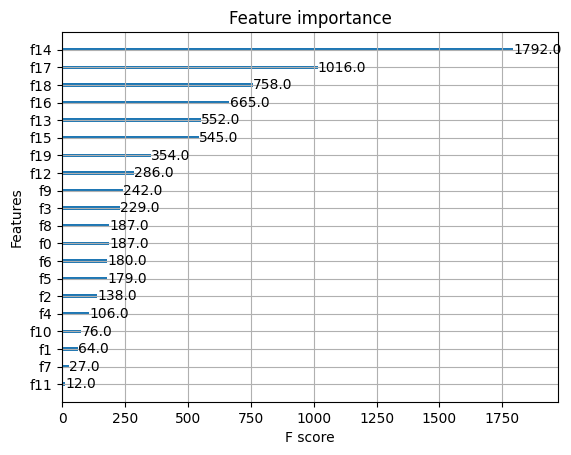

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb)
plt.show()

In [30]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5)
# for train_index, val_index in skf.split(X, y):
#     X_train_fold, X_val_fold = X[train_index], X[val_index]
#     y_train_fold, y_val_fold = y[train_index], y[val_index]
#     # xgb.fit(X_train_fold, y_train_fold)
#     # y_pred_fold = xgb.predict(X_val_fold)
#     # # Evaluate performance on validation fold

#     # xgb = XGBClassifier()
#     # fit_and_score(xgb, 'XGBoost', X_train_fold, X_val_fold, y_train_fold, y_val_fold) 

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [32]:
xgb = XGBClassifier(subsample=1.0, n_estimators=300, max_depth=5, learning_rate=0.05, gamma=0.2, colsample_bytree=0.8)
fit_and_score(xgb, 'XGBoost', X_resampled, X_test, y_resampled, y_test)

XGBoost model
Accuracy: 0.9277858299940319
Precision: 0.7144335230212105
Recall: 0.8239856801909308
F1 Score: 0.7653089498476032
Confusion Matrix: 
[[9501  552]
 [ 295 1381]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10053
           1       0.71      0.82      0.77      1676

    accuracy                           0.93     11729
   macro avg       0.84      0.88      0.86     11729
weighted avg       0.93      0.93      0.93     11729



